In [1]:
import os
import numpy as np
import nibabel as nib
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from tensorflow_addons.layers import GroupNormalization

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [3]:
DATA_DIR = r"brats2021"
PATCH_SIZE = (80,80,80)
BATCH_SIZE = 2
NUM_CLASSES = 4
EPOCHS = 100
LEARNING_RATE = 1e-4

In [4]:
cases = sorted(glob(os.path.join(DATA_DIR, "BraTS2021_*")))
print(len(cases), "cases found")

train_cases, val_cases = train_test_split(cases, test_size=0.2, random_state=42)
print(f"{len(train_cases)} training cases, {len(val_cases)} validation cases")

1251 cases found
1000 training cases, 251 validation cases


In [5]:
def load_case(case_dir):
    case_id = os.path.basename(case_dir)

    t1    = nib.load(os.path.join(case_dir, f"{case_id}_t1.nii.gz")).get_fdata()
    t1ce  = nib.load(os.path.join(case_dir, f"{case_id}_t1ce.nii.gz")).get_fdata()
    t2    = nib.load(os.path.join(case_dir, f"{case_id}_t2.nii.gz")).get_fdata()
    flair = nib.load(os.path.join(case_dir, f"{case_id}_flair.nii.gz")).get_fdata()
    seg   = nib.load(os.path.join(case_dir, f"{case_id}_seg.nii.gz")).get_fdata()

    X = np.stack([t1, t1ce, t2, flair], axis=-1).astype(np.float32)

    for c in range(X.shape[-1]):
        mask = X[..., c] > 0
        if np.any(mask):
            mean = X[..., c][mask].mean()
            std = X[..., c][mask].std() + 1e-8
            X[..., c] = (X[..., c] - mean) / std

    seg = seg.copy()
    seg[seg == 4] = 3 

    return X, seg.astype(np.uint8)


In [6]:
X, y = load_case(cases[0])
print(X.shape, y.shape)   

(240, 240, 155, 4) (240, 240, 155)


In [7]:
def augment(X, y):
    if tf.random.uniform(()) > 0.5:
        X = tf.reverse(X, axis=[0])
        y = tf.reverse(y, axis=[0])
    if tf.random.uniform(()) > 0.5:
        X = tf.reverse(X, axis=[1])
        y = tf.reverse(y, axis=[1])
    if tf.random.uniform(()) > 0.5:
        X = tf.reverse(X, axis=[2])
        y = tf.reverse(y, axis=[2])

    k = int(tf.random.uniform([], 0, 4, dtype=tf.int32).numpy()) 
    if k > 0:
        X = tf.experimental.numpy.rot90(X, k=k, axes=(0, 1))
        y = tf.experimental.numpy.rot90(y, k=k, axes=(0, 1))

    scale = tf.random.uniform([], 0.9, 1.1)
    shift = tf.random.uniform([], -0.1, 0.1)
    X = X * scale + shift

    gamma = tf.random.uniform([], 0.9, 1.1)
    X = tf.sign(X) * (tf.abs(X) ** gamma)

    return X, y


In [8]:
def random_patch(X, y, size=PATCH_SIZE):
    h, w, d, _ = X.shape
    sz, sy, sx = size
    z = np.random.randint(0, h - sz)
    y0 = np.random.randint(0, w - sy)
    x = np.random.randint(0, d - sx)
    return X[z:z+sz, y0:y0+sy, x:x+sx, :], y[z:z+sz, y0:y0+sy, x:x+sx]


def generator(cases):
    while True:
        case = np.random.choice(cases)
        X, y = load_case(case)

        for _ in range(10):  
            Xp, yp = random_patch(X, y)
            if np.mean(yp > 0) > 0.01:
                break

        Xp = Xp.astype(np.float32)
        yp = yp.astype(np.int32)

        Xp, yp = augment(Xp, yp)

        yp_onehot = tf.one_hot(yp, depth=NUM_CLASSES, dtype=tf.float32)

        yield Xp, yp_onehot


In [9]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: generator(train_cases),
    output_signature=(
        tf.TensorSpec(shape=(*PATCH_SIZE, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(*PATCH_SIZE, NUM_CLASSES), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: generator(val_cases),
    output_signature=(
        tf.TensorSpec(shape=(*PATCH_SIZE, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(*PATCH_SIZE, NUM_CLASSES), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
def se_block(x, ratio=8):
    filters = tf.shape(x)[-1]
    f = x.shape[-1]
    se = layers.GlobalAveragePooling3D()(x)
    se = layers.Dense(max(f // ratio, 4), activation="relu")(se)
    se = layers.Dense(f, activation="sigmoid")(se)
    se = layers.Reshape((1,1,1,f))(se)
    return layers.Multiply()([x, se])

def residual_block(x, filters, kernel_size=3):
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, 1, padding="same")(shortcut)
        shortcut = GroupNormalization(groups=8)(shortcut)

    x = layers.Conv3D(filters, kernel_size, padding="same")(x)
    x = GroupNormalization(groups=8)(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv3D(filters, kernel_size, padding="same")(x)
    x = GroupNormalization(groups=8)(x)

    x = layers.Add()([shortcut, x])
    x = layers.Activation("relu")(x)

    x = se_block(x)
    return x

def attention_gate(skip, gating, inter_channels):
    theta_x = layers.Conv3D(inter_channels, 1, padding="same")(skip)
    phi_g   = layers.Conv3D(inter_channels, 1, padding="same")(gating)
    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation("relu")(add)
    psi = layers.Conv3D(1, 1, padding="same")(act)
    psi = layers.Activation("sigmoid")(psi)
    out = layers.Multiply()([skip, psi])  
    return out


def encoder_block(x, filters):
    x = residual_block(x, filters)
    p = layers.MaxPool3D((2,2,2))(x)
    return x, p

def decoder_block(x, skip, filters):
    x = layers.Conv3DTranspose(filters, (2,2,2), strides=(2,2,2), padding="same")(x)
    att = attention_gate(skip, x, inter_channels=max(filters//4, 8))
    x = layers.Concatenate()([x, att])
    x = residual_block(x, filters)
    return x

def build_unet(input_shape=(80,80,80,4), num_classes=4):
    inputs = keras.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b = residual_block(p4, 512)

    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = layers.Conv3D(num_classes, 1, activation="softmax", dtype="float32")(d4)
    model = keras.Model(inputs, outputs, name="3D-U-Net")
    return model

In [11]:
def tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    TP = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    FP = tf.reduce_sum((1 - y_true_f) * y_pred_f, axis=0)
    FN = tf.reduce_sum(y_true_f * (1 - y_pred_f), axis=0)

    tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return 1.0 - tf.reduce_mean(tversky)


def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    ce_per_voxel = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    ce = tf.reduce_mean(ce_per_voxel)   # mean over voxels (and batch dim if present)
    tv = tversky_loss(y_true, y_pred)
    return ce + tv


In [12]:
class DiceScore(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, smooth=1e-6, name="mean_dice", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.inter = self.add_weight(name="inter", shape=(num_classes,), initializer="zeros")
        self.union = self.add_weight(name="union", shape=(num_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.nn.softmax(y_pred, axis=-1)
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), self.num_classes)
        inter = tf.reduce_sum(y_true * y_pred, axis=[0,1,2,3])
        union = tf.reduce_sum(y_true + y_pred, axis=[0,1,2,3])
        self.inter.assign_add(inter)
        self.union.assign_add(union)

    def result(self):
        dice = (2. * self.inter + self.smooth) / (self.union + self.smooth)
        return tf.reduce_mean(dice)

    def reset_states(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))

In [13]:
opt = keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(LEARNING_RATE)
)

In [14]:
model = build_unet(input_shape=(*PATCH_SIZE, 4), num_classes=NUM_CLASSES)
model.compile(
    optimizer=opt,
    loss=combined_loss,
    metrics=[DiceScore(num_classes=NUM_CLASSES)]
)
model.load_weights("brats3d_best")

In [15]:
model.summary()

Model: "3D-U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 80,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv3d_1 (Conv3D)              (None, 80, 80, 80,   3488        ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 group_normalization_1 (GroupNo  (None, 80, 80, 80,   64         ['conv3d_1[0][0]']               
 rmalization)                   32)                                                        

In [16]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
    keras.callbacks.ModelCheckpoint("brats3d_best", save_best_only=True, save_weights_only=True, verbose=1)
]

In [18]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=100,    
    initial_epoch=65,
    validation_steps=20,
    callbacks=callbacks
)

Epoch 66/100
100/100 [==============================] - ETA: 0s - loss: 0.2340 - mean_dice: 0.8740

c:\Users\ishan\anaconda3\envs\ML\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric DiceScore implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 66: val_loss improved from inf to 0.21874, saving model to brats3d_best
100/100 [==============================] - 436s 4s/step - loss: 0.2340 - mean_dice: 0.8740 - val_loss: 0.2187 - val_mean_dice: 0.8878 - lr: 6.2500e-06
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 0.2025 - mean_dice: 0.8981
Epoch 67: val_loss improved from 0.21874 to 0.20079, saving model to brats3d_best
100/100 [==============================] - 487s 5s/step - loss: 0.2025 - mean_dice: 0.8981 - val_loss: 0.2008 - val_mean_dice: 0.9032 - lr: 6.2500e-06
Epoch 68/100
100/100 [==============================] - ETA: 0s - loss: 0.2291 - mean_dice: 0.8802
Epoch 68: val_loss did not improve from 0.20079
100/100 [==============================] - 373s 4s/step - loss: 0.2291 - mean_dice: 0.8802 - val_loss: 0.2321 - val_mean_dice: 0.8588 - lr: 6.2500e-06
Epoch 69/100
100/100 [==============================] - ETA: 0s - loss: 0.2445 - mean_dice: 0.8746
Epoch 69: val_loss did not improve from 0

KeyboardInterrupt: 

In [19]:
model.save("brats_unet_modelv5")

INFO:tensorflow:Assets written to: brats_unet_modelv5\assets


INFO:tensorflow:Assets written to: brats_unet_modelv5\assets


In [ ]:
model=keras.models.load_model("brats_unet_modelv4",compile=False)

In [20]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denom = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice


Xp, yp = next(generator(cases)) 
yp_pred = model.predict(np.expand_dims(Xp,0))[0]

dice_scores = dice_coef(yp, yp_pred)
print("Dice per class:", dice_scores.numpy())


1/1 [==============================] - 2s 2s/step
Dice per class: [0.9940497  0.92354655 0.9512537  0.9334397 ]


1/1 [==============================] - 0s 49ms/step


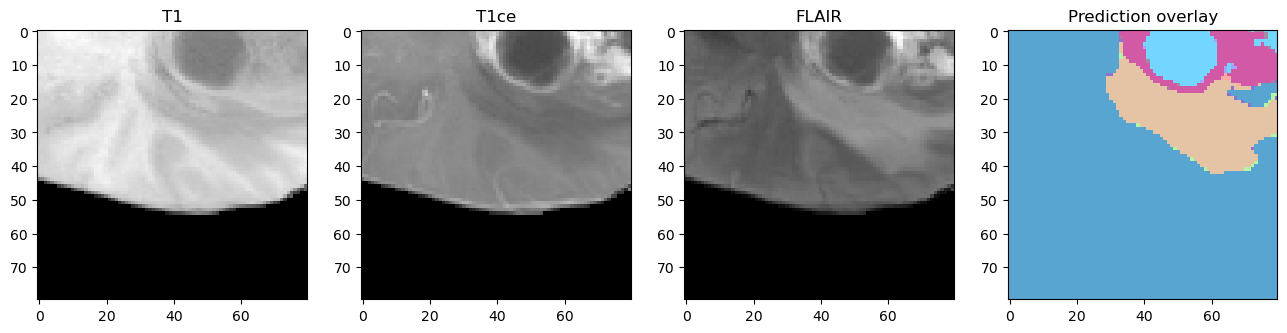

In [27]:

def show_slice(X, y_true, y_pred, slice_idx):
    if y_true.ndim==4: 
        y_true = np.argmax(y_true, axis=-1)
    if y_pred.ndim==4:
        y_pred = np.argmax(y_pred, axis=-1)

    fig, axes = plt.subplots(1,4, figsize=(16,4))
    axes[0].imshow(X[:,:,slice_idx,0], cmap='gray'); axes[0].set_title("T1")
    axes[1].imshow(X[:,:,slice_idx,1], cmap='gray'); axes[1].set_title("T1ce")
    axes[2].imshow(X[:,:,slice_idx,3], cmap='gray'); axes[2].set_title("FLAIR")
    axes[3].imshow(y_pred[:,:,slice_idx], cmap='jet', alpha=0.5)
    axes[3].imshow(y_true[:,:,slice_idx], cmap='cool', alpha=0.3)
    axes[3].set_title("Prediction overlay")
    plt.show()

Xp, yp = next(generator(cases))
yp_pred = model.predict(np.expand_dims(Xp,0))[0]
show_slice(Xp, yp, yp_pred, slice_idx=70)


In [ ]:

def predict_full_volume(model, X, patch_size=(80,80,80), overlap=32):
    h, w, d, c = X.shape
    ph, pw, pd = patch_size
    stride = (ph - overlap, pw - overlap, pd - overlap)

    prob_map = np.zeros((h, w, d, 4), dtype=np.float32)
    count_map = np.zeros((h, w, d, 4), dtype=np.float32)

    for z in range(0, h - ph + 1, stride[0]):
        for y in range(0, w - pw + 1, stride[1]):
            for x in range(0, d - pd + 1, stride[2]):
                patch = X[z:z+ph, y:y+pw, x:x+pd, :]
                patch = np.expand_dims(patch, 0)  # add batch
                pred = model.predict(patch, verbose=0)[0]

                prob_map[z:z+ph, y:y+pw, x:x+pd, :] += pred
                count_map[z:z+ph, y:y+pw, x:x+pd, :] += 1
    
    prob_map /= np.maximum(count_map, 1e-8)
    return np.argmax(prob_map, axis=-1)   


In [29]:
def show_slices(X, y_true, y_pred, slice_idx=None):
    if slice_idx is None:
        slice_idx = X.shape[2] // 2  

    flair = X[:,:,slice_idx,3]   
    true_mask = y_true[:,:,slice_idx]
    pred_mask = y_pred[:,:,slice_idx]

    class_labels = {
        0: "Background",
        1: "Necrotic tumor core",
        2: "Peritumoral invaded tissue",
        3: "GD-enhancing tumor"
    }

    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].imshow(flair, cmap="gray"); axs[0].set_title("FLAIR (input)")
    im1 = axs[1].imshow(true_mask, cmap="tab10", vmin=0, vmax=len(class_labels)-1)
    axs[1].set_title("Ground Truth")
    im2 = axs[2].imshow(pred_mask, cmap="tab10", vmin=0, vmax=len(class_labels)-1)
    axs[2].set_title("Prediction")

    for ax in axs: ax.axis("off")

    cmap = plt.cm.get_cmap("tab10", len(class_labels))
    patches = [mpatches.Patch(color=cmap(i), label=label) 
               for i, label in class_labels.items()]
    
    fig.legend(handles=patches, loc="lower center", ncol=4, fontsize=10)
    plt.tight_layout(rect=[0,0.08,1,1])  
    plt.show()


C:\Users\ishan\AppData\Local\Temp\ipykernel_21260\3199333315.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(class_labels))


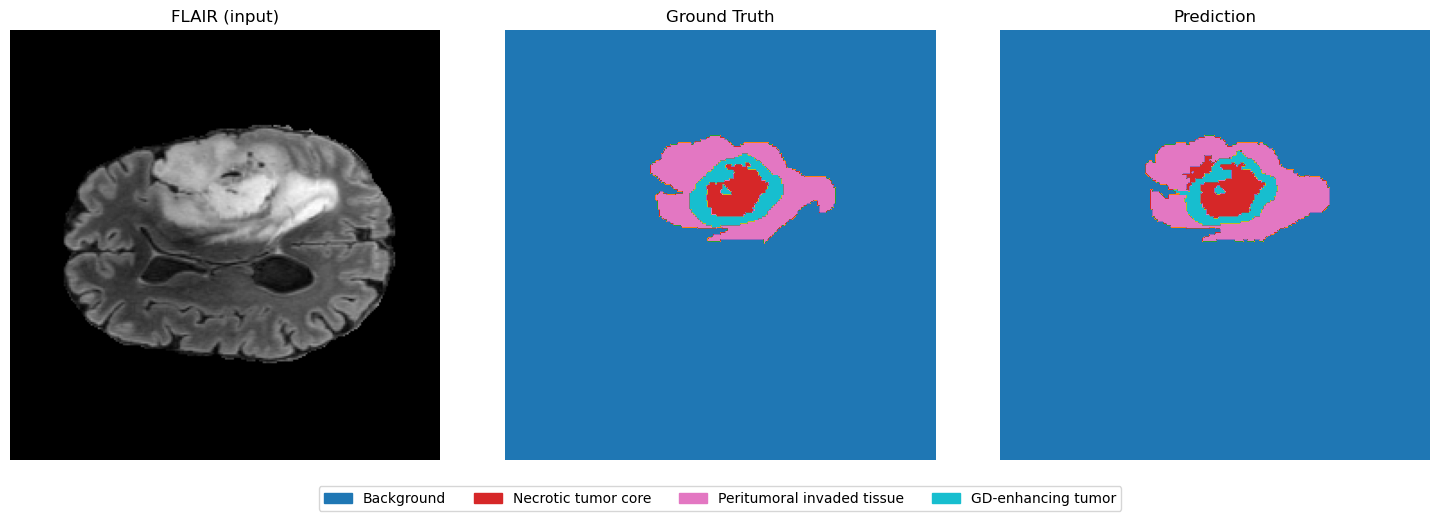

In [30]:
X, y = load_case(cases[40])

y_pred = predict_full_volume(model, X, patch_size=(80,80,80), overlap=32)

show_slices(X, y, y_pred, slice_idx=80)


In [31]:
import numpy as np
from tqdm import tqdm 

def dice_coef_numpy(y_true, y_pred, label, smooth=1e-6):
    """
    Calculates the Dice coefficient for a specific class label using NumPy.
    """
    y_true_bin = (y_true == label).astype(np.float32)
    y_pred_bin = (y_pred == label).astype(np.float32)
    
    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin)
    
    return (2. * intersection + smooth) / (union + smooth)

def evaluate_test_set(model, test_cases, num_classes=4, patch_size=(80,80,80), overlap=32):

    dice_scores_per_class = {i: [] for i in range(1, num_classes)} # Only for foreground classes

    for case_path in tqdm(test_cases, desc="Evaluating Test Set"):
        X, y_true = load_case(case_path)
        
        y_pred = predict_full_volume(model, X, patch_size=patch_size, overlap=overlap)
        
        for label in range(1, num_classes):
            dice = dice_coef_numpy(y_true, y_pred, label)
            dice_scores_per_class[label].append(dice)
            
    results = {}
    for label, scores in dice_scores_per_class.items():
        mean_dice = np.mean(scores)
        std_dice = np.std(scores)
        results[label] = (mean_dice, std_dice)
        
    return results

In [33]:
evaluation_results = evaluate_test_set(model, test_cases=val_cases[:20])

# 3. Print the results in a readable format
class_labels = {
    1: "Necrotic tumor core (NCR)",
    2: "Peritumoral edema (ED)",
    3: "GD-enhancing tumor (ET)"
}

print("\n--- Final Evaluation Results (Mean Dice ± Std) ---")
for label, (mean, std) in evaluation_results.items():
    print(f"{class_labels[label]:<30}: {mean:.4f} ± {std:.4f}")

# You can also calculate the average across just the tumor classes
tumor_dice_means = [results[0] for label, results in evaluation_results.items()]
print(f"\n{'Average Tumor Dice':<30}: {np.mean(tumor_dice_means):.4f}")

Evaluating Test Set: 100%|██████████| 20/20 [07:54<00:00, 23.75s/it]


--- Final Evaluation Results (Mean Dice ± Std) ---
Necrotic tumor core (NCR)     : 0.7395 ± 0.2981
Peritumoral edema (ED)        : 0.7745 ± 0.1604
GD-enhancing tumor (ET)       : 0.7945 ± 0.2731

Average Tumor Dice            : 0.7695
